In [1]:
import matplotlib.pyplot as plt
import polars as pl
from scipy import stats
import seaborn as sns

from lib import (
    load_dataset,
    compute_accuracy_results,
    process_parameter_dataset,
    process_runtime_dataset,
    validate_parameter_dataset,
    apply_hypothesis_test,
    save_figure,
    save_table,
    normalized,
    format_network_types,
)

pl.Config.set_fmt_str_lengths(36);

## Experiment 1: Parameters

In [2]:
parameter = "send_coefficient"
parameter_title = parameter.replace('_', ' ').capitalize()
parameter_symbol = "\gamma"

df = load_dataset("send-coefficient")
validate_parameter_dataset(df)

In [3]:
results = compute_accuracy_results(
    process_parameter_dataset(df),
    parameter=parameter,
    percentiles=[0, 0.01, 0.1, *range(1, 7), 21],
)

min_parameter = results.counts[parameter].min()

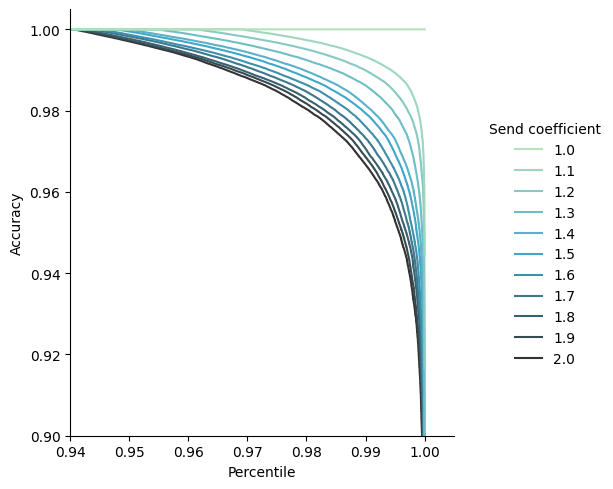

In [4]:
output_path = "outputs/accuracy_aggregate"

data = results.tabular.filter(pl.col(parameter) >= min_parameter)

g = sns.displot(
    data,
    kind="ecdf",
    y="accuracy",
    complementary=True,
    hue=parameter,
    palette="GnBu_d",
    height=5,
)

g.set(xlim=(0.94, 1.005), ylim=(0.90, 1.005))
g.set_axis_labels("Percentile", "Accuracy")
g.legend.set_title(parameter_title)

plt.show()

In [5]:
save_figure(g, output_path)
save_table(results.wide_percentiles, output_path)

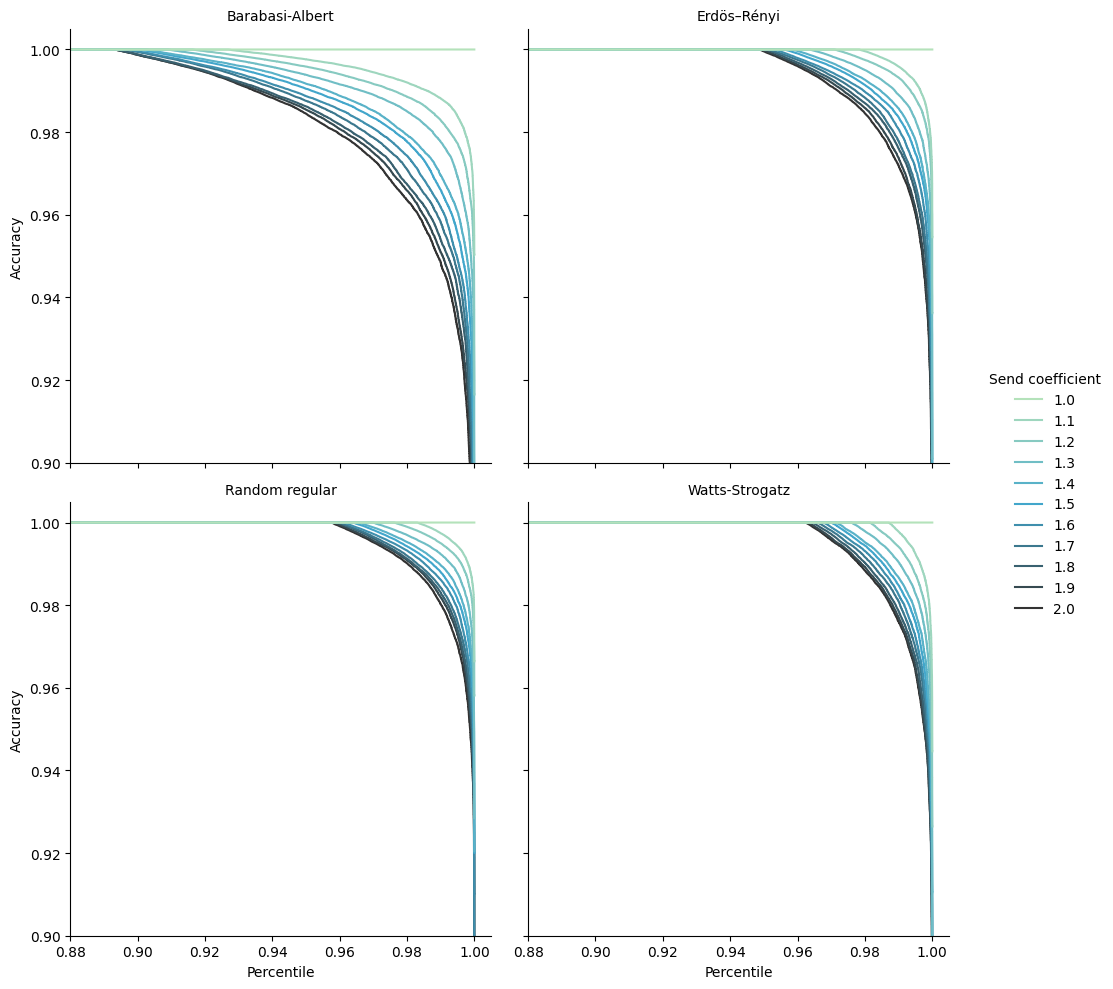

In [6]:
output_path = "outputs/accuracy_network-type"

data = results.tabular.filter(pl.col(parameter) >= min_parameter)

data = format_network_types(data)

g = sns.displot(
    data,
    kind="ecdf",
    y="accuracy",
    complementary=True,
    col="network_type",
    col_wrap=2,
    col_order=data["network_type"].unique().sort(),
    hue=parameter,
    palette="GnBu_d",
)

g.set(xlim=(0.88, 1.005), ylim=(0.90, 1.005))
g.set_axis_labels("Percentile", "Accuracy")
g.set_titles("{col_name}")
g.legend.set_title(parameter_title)

plt.show()

In [7]:
save_figure(g, output_path)

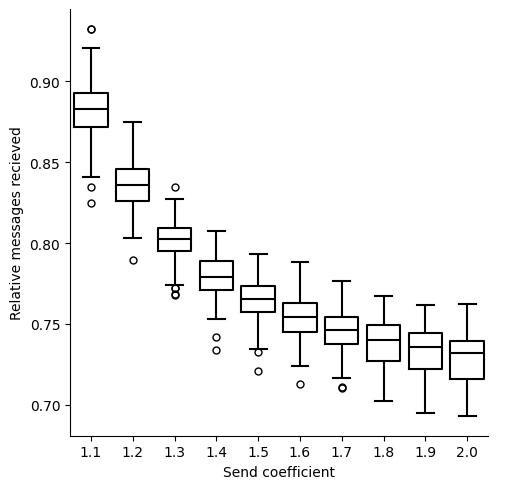

In [9]:
data = (
    df.filter(pl.col(parameter) >= min_parameter)
    .with_columns(pl.col("n_receives").list.sum())
    .with_columns(
        normalized("n_receives", by="max")
        .over("dataset_id", "network_source", "score_source")
        .alias("normalized_n_receives")
    )
    .filter(pl.col(parameter) > min_parameter)
    .to_pandas()
)

g = sns.catplot(
    data, kind="box", x=parameter, y="normalized_n_receives", fill=None, color="black"
)

g.set_ylabels("Relative messages recieved")
g.set_xlabels(parameter_title)

plt.show()

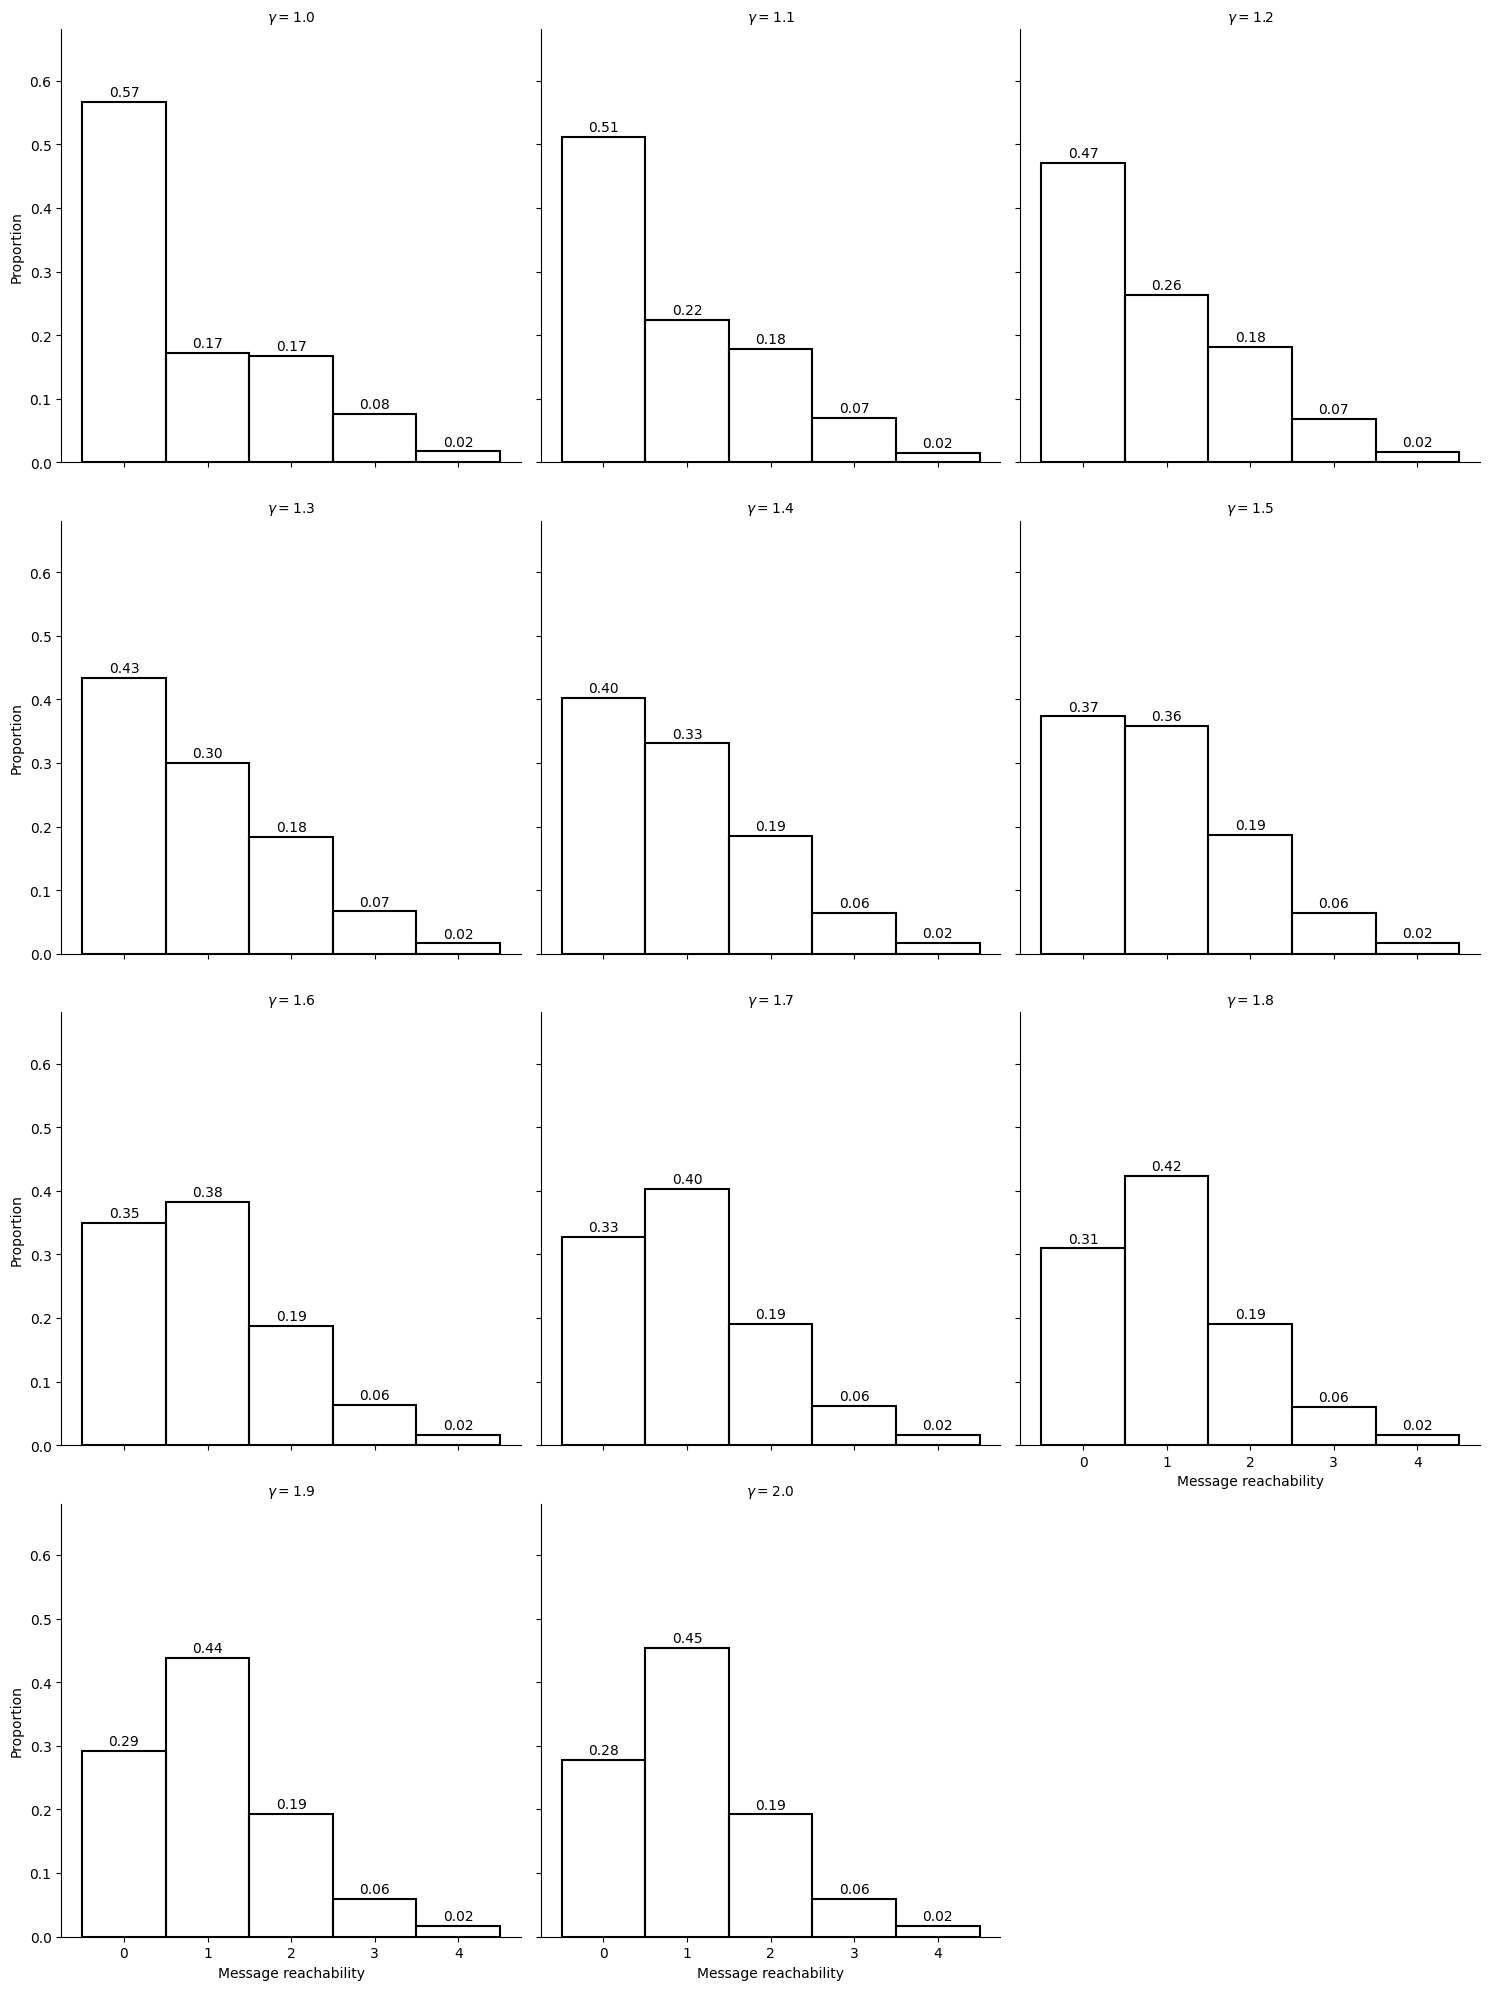

In [10]:
data = df.filter(pl.col(parameter) >= min_parameter)

data = process_parameter_dataset(data)

g = sns.displot(
    data,
    kind="hist",
    x="msg_reachability",
    col=parameter,
    col_wrap=3,
    discrete=True,
    stat="proportion",
    binrange=(0, 4),
    fill=False,
    color="black",
    common_norm=False,
)
g.set_titles(col_template=f"${parameter_symbol} = {{col_name}}$")
g.set_xlabels("Message reachability")
# Ref: https://stackoverflow.com/a/67561982
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0], fmt="%.2f", padding=2)
    ax.margins(y=0.2)

plt.show()

In [11]:
save_figure(g, "outputs/efficiency_message-reachability_by-value")

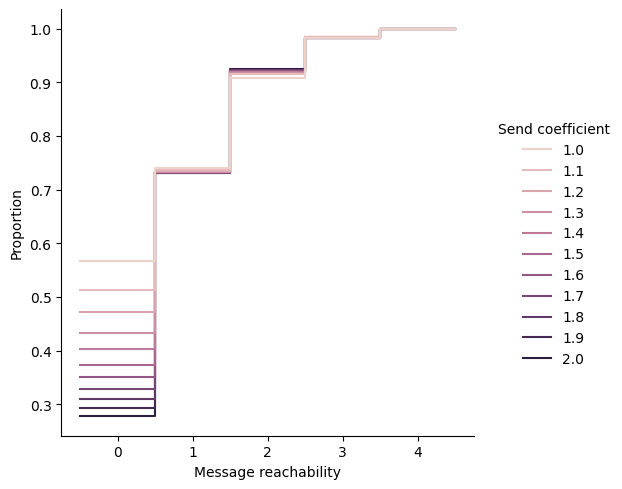

In [12]:
data = df.filter(pl.col(parameter) >= min_parameter)

data = process_parameter_dataset(data)

g = sns.displot(
    data,
    kind="hist",
    x="msg_reachability",
    stat="proportion",
    hue=parameter,
    discrete=True,
    cumulative=True,
    binrange=(0, 4),
    fill=False,
    element="step",
    common_norm=False,
)

g.set_xlabels("Message reachability")
g.legend.set_title(parameter_title)

plt.show()

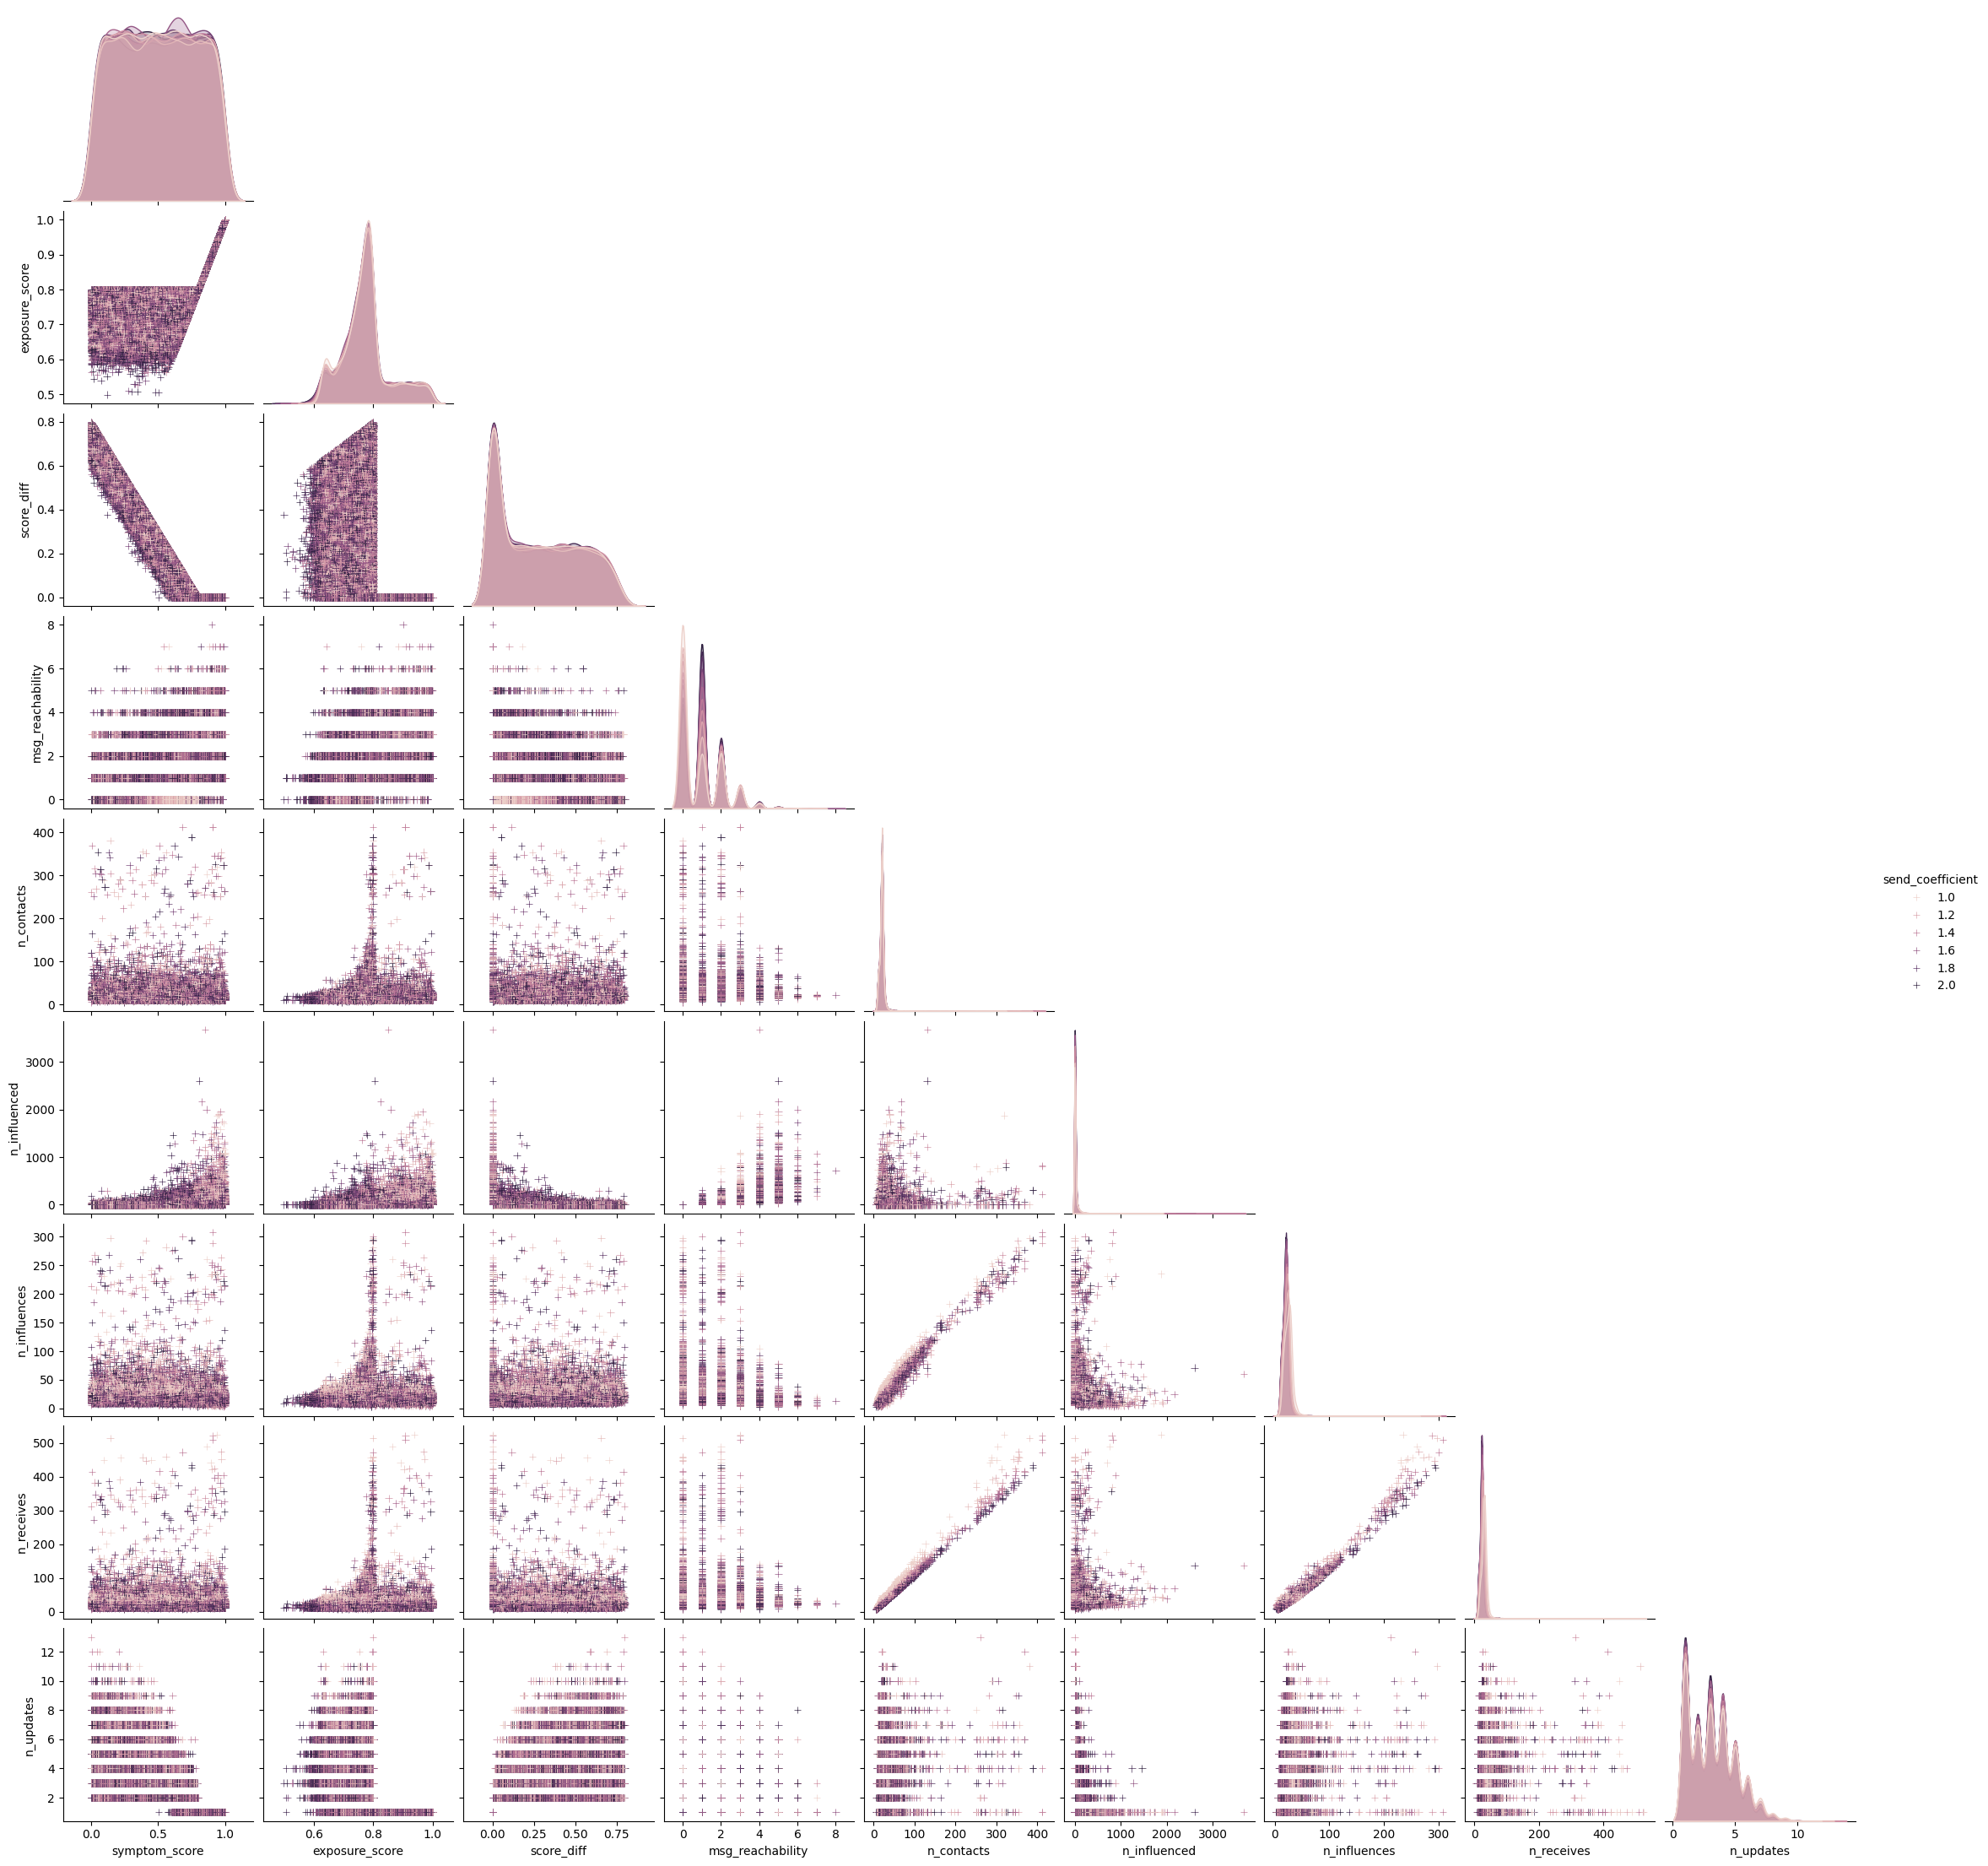

In [60]:
data = df.filter(pl.col(parameter) >= min_parameter)
data = process_parameter_dataset(data)
data = data.sample(fraction=0.01)
data = data.with_columns(symptom_score=pl.col("exposure_score") - pl.col("score_diff"))
data = data.to_pandas()

sns.pairplot(
    data,
    vars=[
        "symptom_score",
        "exposure_score",
        "score_diff",
        "msg_reachability",
        "n_contacts",
        "n_influenced",
        "n_influences",
        "n_receives",
        "n_updates",
    ],
    hue="send_coefficient",
    corner=True,
    plot_kws={"marker": "+"},
)

plt.show()

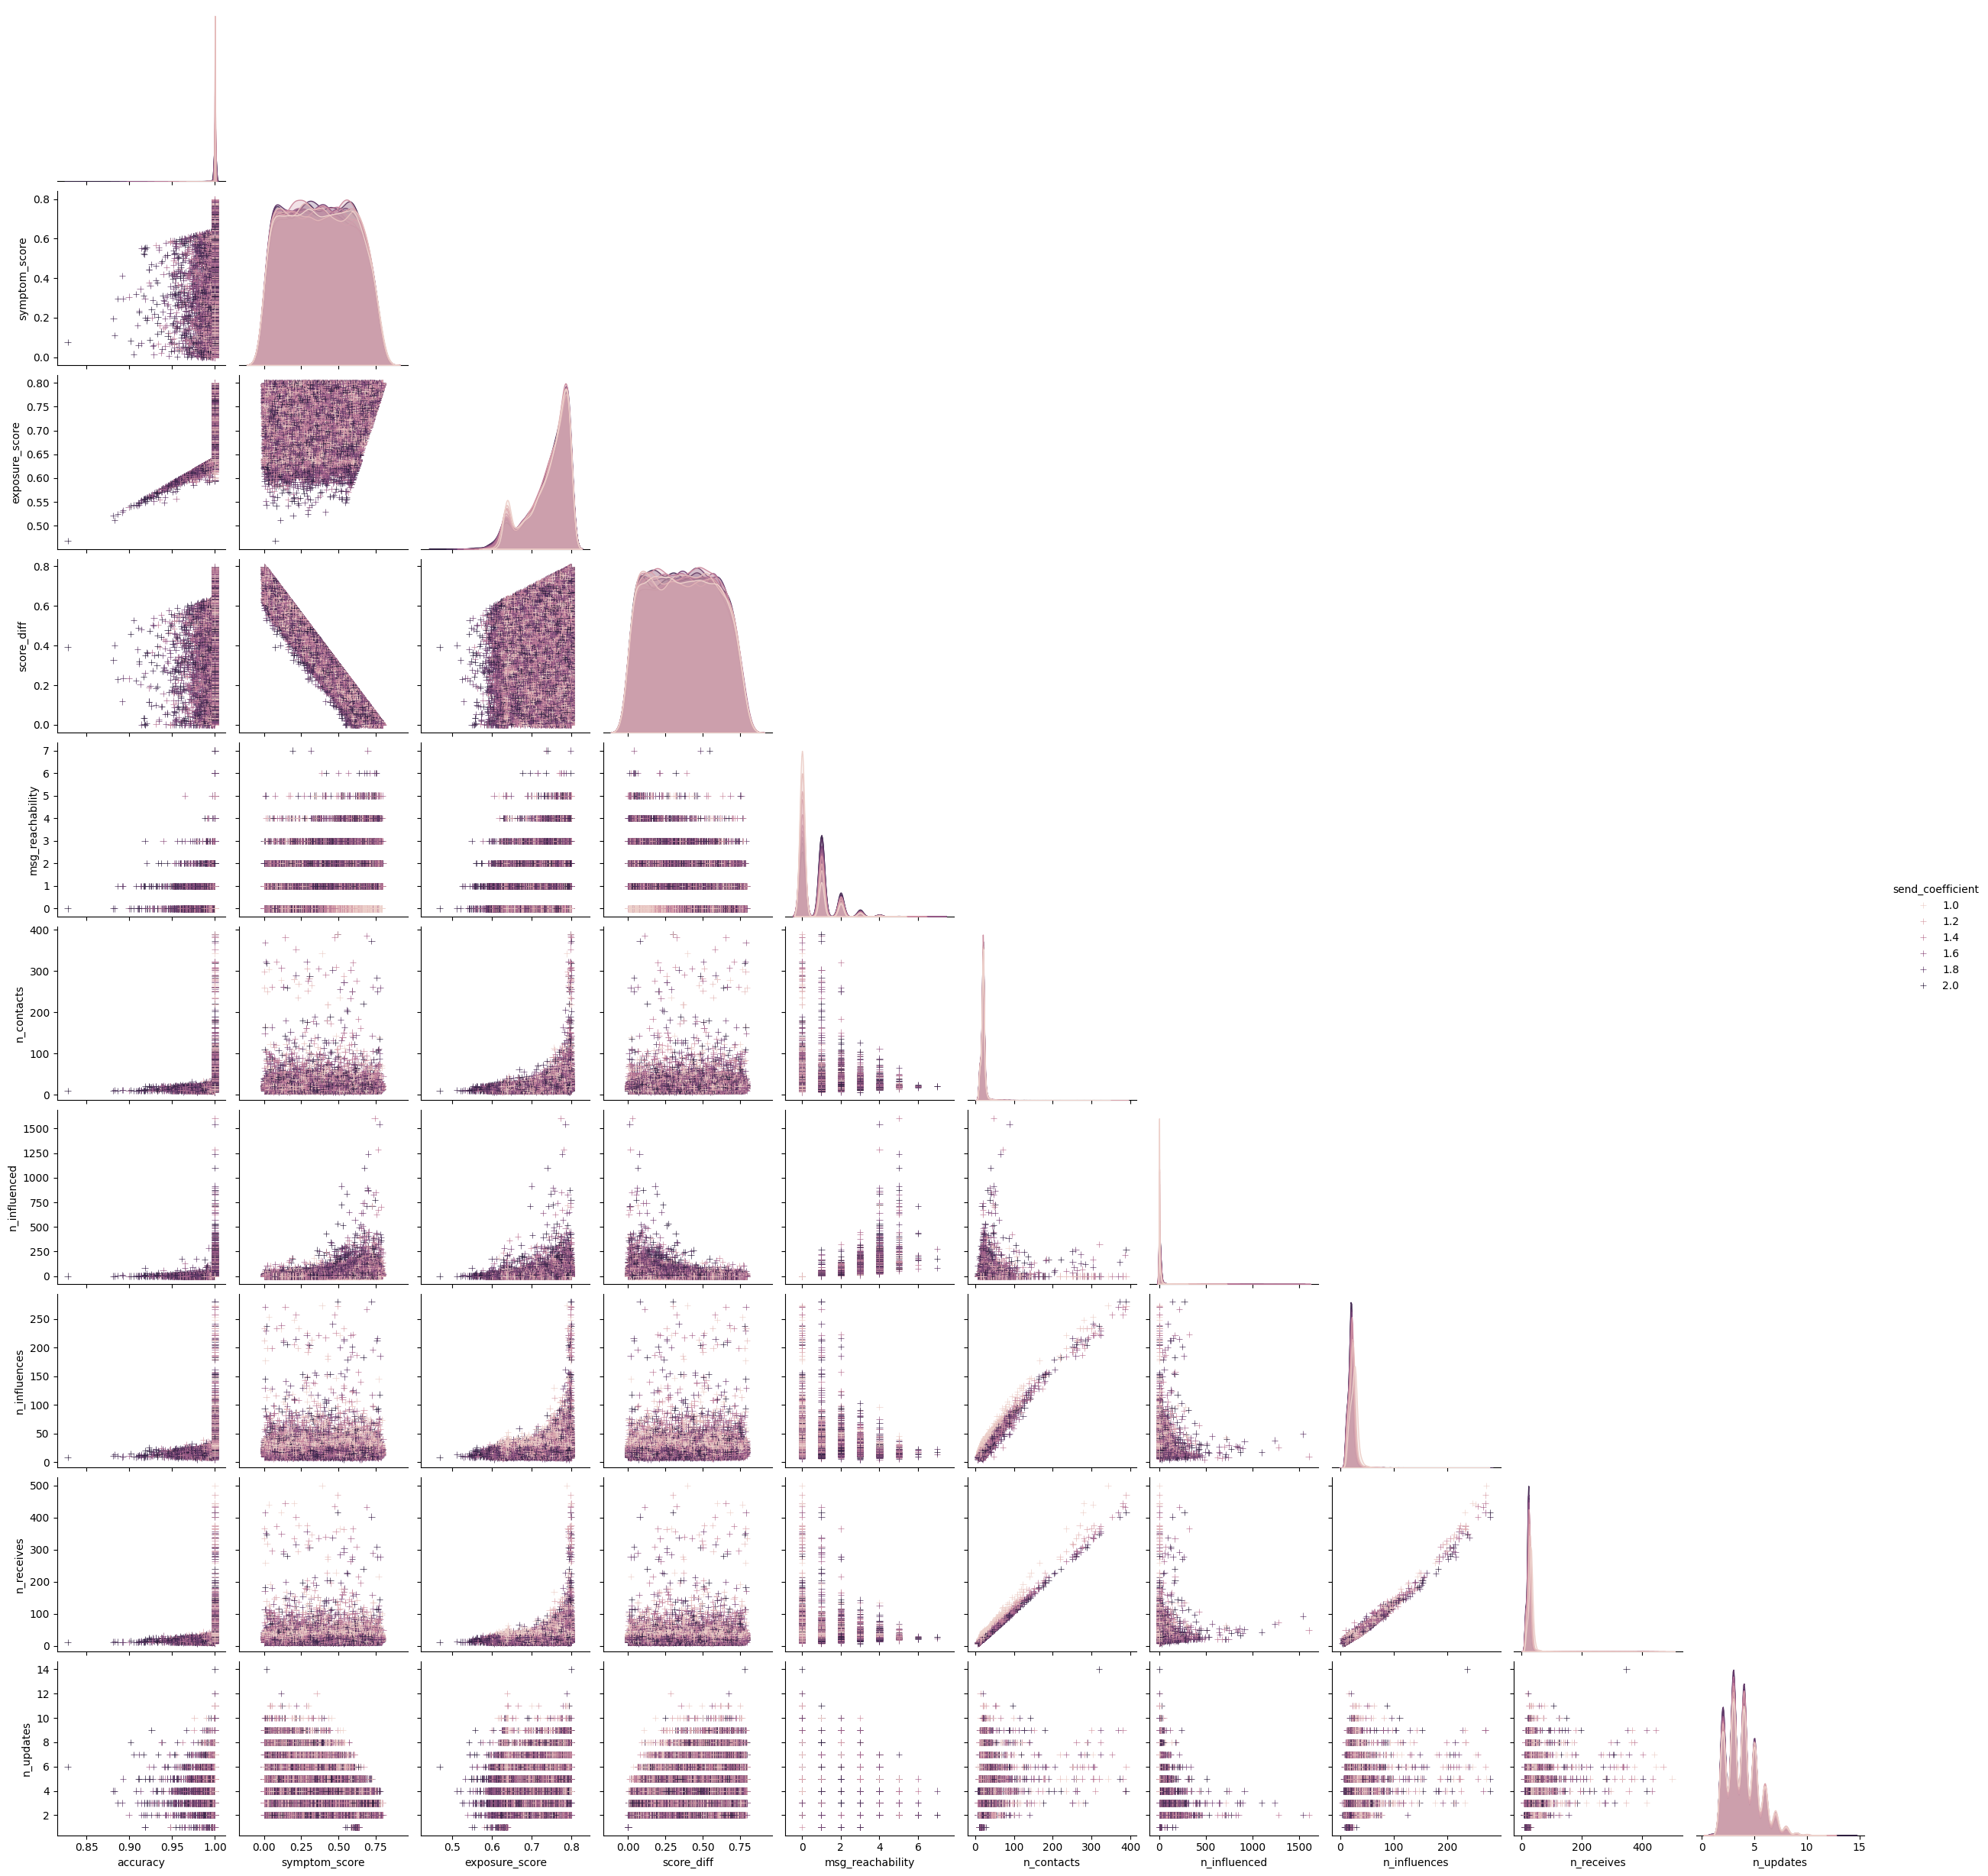

In [61]:
data = results.tabular.filter(pl.col(parameter) >= min_parameter)
data = data.sample(fraction=0.01)
data = data.with_columns(symptom_score=pl.col("exposure_score") - pl.col("score_diff"))
data = data.to_pandas()

sns.pairplot(
    data,
    vars=[
        "accuracy",
        "symptom_score",
        "exposure_score",
        "score_diff",
        "msg_reachability",
        "n_contacts",
        "n_influenced",
        "n_influences",
        "n_receives",
        "n_updates",
    ],
    hue="send_coefficient",
    corner=True,
    plot_kws={"marker": "+"},
)

plt.show()

### Tolerance

In [ ]:
df = load_dataset('tolerance')

In [ ]:
results = compute_accuracy_results(
    process_parameter_dataset(df),
    parameter="tolerance",
    percentiles=[0, 0.01, 0.1, 1],
)

In [ ]:
data = df
data = data.with_columns(pl.col("n_receives").list.sum())
data = data.with_columns(
    normalized("n_receives", by="max")
    .over("dataset_id", "network_source", "score_source")
    .alias("n_receives_norm")
)
percentiles = results.percentiles
data = data.join(percentiles, on='tolerance')

g = sns.FacetGrid(
    data.to_pandas(),
    hue="tolerance",
    height=4,
    aspect=2,
    sharex=False,
    sharey=False,
)

g.map_dataframe(sns.boxplot, "tolerance", "n_receives_norm")
g.map_dataframe(sns.pointplot, "tolerance", "0")
g.set_axis_labels("Tolerance", "Proportion")
g.add_legend()

plt.show()

## Experiment 2: Runtime baseline

**Objective**: Determine if the runtime across distribution types is the same.

In [ ]:
df = load_dataset('runtime-baseline')
df = process_runtime_dataset(df)


ANOVA assumes normality. Use the Shapiro-Wilks test.

https://en.wikipedia.org/wiki/Analysis_of_variance#Assumptions

https://www.pythonfordatascience.org/parametric-assumptions-python

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro

In [ ]:
apply_hypothesis_test(df, stats.shapiro, by_distributions=True)

In [ ]:
apply_hypothesis_test(df, stats.shapiro, by_distributions=True, by_network_type=True)

The $p$ values are very low, which suggests the null hypothesis of normality is rejected.

To use non-parametric ANOVA, we must still ensure the homoscedasticity assumption holds.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fligner.html

In [ ]:
apply_hypothesis_test(df, stats.fligner, by_distributions=True)

In [ ]:
apply_hypothesis_test(df, stats.fligner, by_distributions=True, by_network_type=True)

The $p$ value is high, which indicates the null hypothesis of homoscedasticity cannot be rejected.

The Kruskal-Wallis test is the non-parametric equivalent of one-way ANOVA.

https://en.wikipedia.org/wiki/Kruskal–Wallis_test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal

In [ ]:
apply_hypothesis_test(df, stats.kruskal, by_distributions=True)

In [ ]:
apply_hypothesis_test(df, stats.kruskal, by_distributions=True, by_network_type=True)

A high $p$ value indicates that the null hypothesis cannot be rejected.

**Conclusion:** There is no statistically significant difference in runtime across data distributions.

## Runtime experiment

In [ ]:
df = load_dataset("runtime")
df = process_runtime_dataset(df)